In [ ]:
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.

In [45]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [46]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

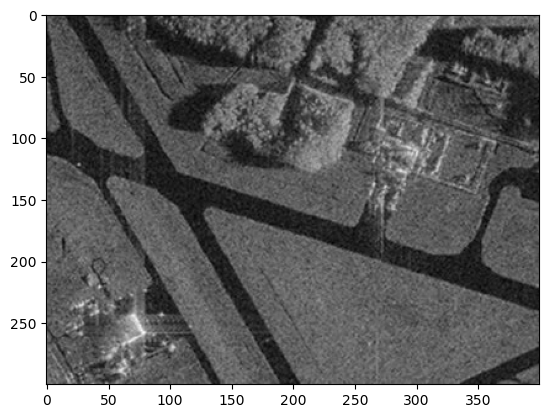

In [47]:
plt.imshow(image_gray, cmap="gray")

In [48]:
import math
def homo_average(img, mask, point, T):
    av_val = np.median(img[mask > 0]) 
    if abs(av_val - img[point]) <= T:
        return True                    # если среднее (медианное) значение по области действия маски сравнимо со значением в точке
    return False

In [49]:
def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image_gray.shape, np.uint8) 
    mask[seed_point] = 1                                                     # установить начальное значение маски в точке (250, 300)
    count = 1 
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i,j] == 0 and mask[i-r : i+r, j-r : j+r].sum() > 0:
                    if homo_average(image, mask, (i,j), T):                  # как только встретим дорогу, то получим среднее значение в области действия маски отличное от значения в точке более чем на T
                        local_mask[i,j] = 1                                  # наращиваем все точки (i, j), которые удовлетворяют условию
        count = np.count_nonzero(local_mask)                                 # остановимся, когда нарастить количество точек более невозможно
        mask += local_mask                                                   # разрастание маски
        
    return mask*255

In [50]:
point = (250, 300) # начальная точка
r = 5  # радиус поиска
T = 20 # пороговое значение сравнения

mask = region_growing(image_gray, point, homo_average, r, T)

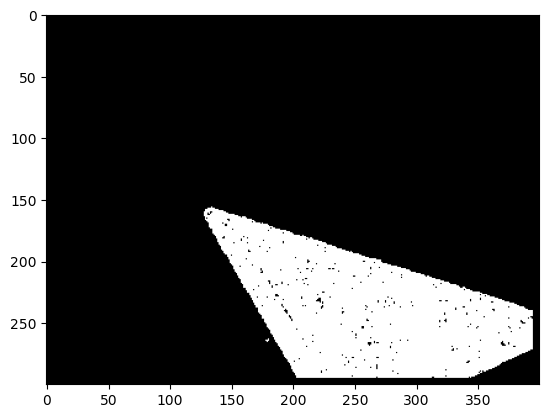

In [51]:
plt.imshow(mask, cmap="gray")

In [52]:
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.

In [53]:
z = np.float32(image_gray.reshape((-1,3)))

# количество кластеров (яркостей)
K1 = 2
K2 = 3
K3 = 10

# количество итераций 5, точность 0.1
criteria1 = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 5, 0.1) 

# количество итераций 5, точность 1
criteria2 = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 5, 1.0) 

# количество итераций 90, точность 0.1
criteria3 = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 90, 0.1)

ret1, label1, center1 = cv2.kmeans(z, K1, None, criteria1, 10, cv2.KMEANS_RANDOM_CENTERS)
ret2, label2, center2 = cv2.kmeans(z, K2, None, criteria2, 10, cv2.KMEANS_RANDOM_CENTERS)
ret3, label3, center3 = cv2.kmeans(z, K3, None, criteria3, 50, cv2.KMEANS_RANDOM_CENTERS)

# восстановление изображения
center1 = np.uint8(center1)
res = center1[label1.flatten()]
res1 = res.reshape((image_gray.shape))

center2 = np.uint8(center2)
res = center2[label2.flatten()]
res2 = res.reshape((image_gray.shape))

center3 = np.uint8(center3)
res = center3[label3.flatten()]
res3 = res.reshape((image_gray.shape))

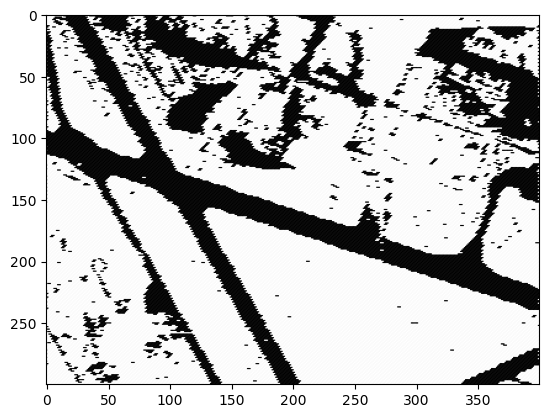

In [54]:
plt.imshow(res1, cmap="gray")

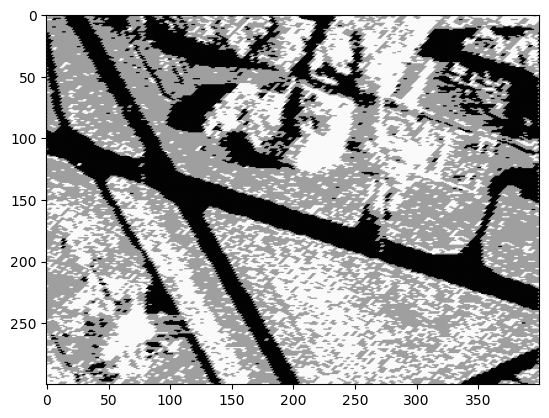

In [55]:
plt.imshow(res2, cmap="gray")

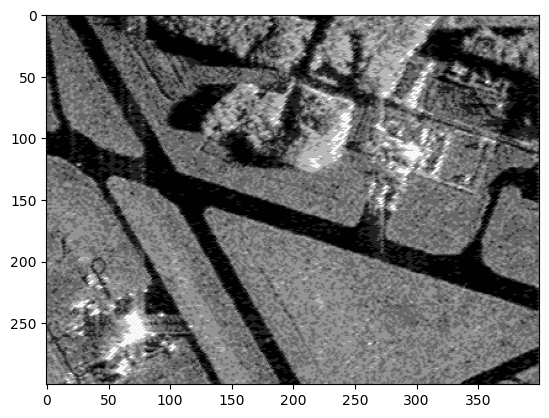

In [56]:
plt.imshow(res3, cmap="gray")

In [57]:
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [66]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [67]:
palm = cv2.imread("palm_1.JPG")
palm_gray = cv2.cvtColor(palm, cv2.COLOR_BGR2GRAY)

In [68]:
palm_gb = cv2.GaussianBlur(palm_gray, (11, 11), 0) # сглаживание изображения по Гауссу

ret, thresh = cv2.threshold(palm_gb, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) 
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 

ret, sure_fg = cv2.threshold(dist, 0.58 * dist.max(), 255, cv2.THRESH_BINARY) 
sure_fg = sure_fg.astype(np.uint8)

In [69]:
ret, mark = cv2.connectedComponents(sure_fg) # поиск связных компонент
mark = cv2.watershed(palm, mark.astype(np.int32)) # формирование массива меток по методу "водораздела"

count = len(np.unique(mark)) - 1 # количество пальм с погрешностью 5-10 шт. ~ числу элементов сформированного массива (по меткам)

In [70]:
palm_res = palm.copy()
palm_res[mark == -1] = [255, 0, 0] # обозначение границ, где не определено mark

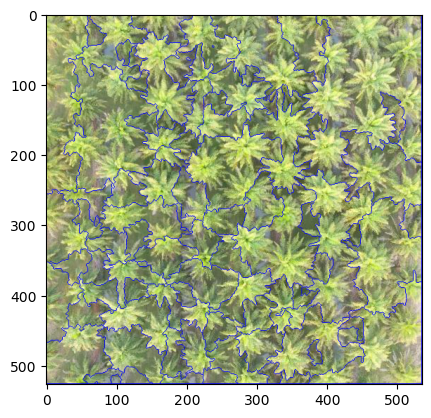

In [71]:
plt.imshow(cv2.cvtColor(palm_res, cv2.COLOR_BGR2RGB))

In [72]:
print("Ответ : ", count)

Ответ :  97
